В этом уроке изучим вопросы мультиколлинеарности и отбора переменных в модели множественной линейной регрессии.

Ссылка на файл для экспериментов

https://docs.google.com/spreadsheets/d/1ilgN4nUDdtKdJRGGccQV_eXb3x9EMaAx/edit?usp=share_link&ouid=114299830697284631791&rtpof=true&sd=true

Все зависимости (если есть) в этом датасете только линейные, нелинейных зависимостей нет.

Здесь $u$ - зависимая переменная, которую требуется объяснить / предсказать. То есть требуется построить модель множественной линейной регрессии.

В качестве потенциальных предикторов рассматриваем $x, y, t$ и $z$.
Требуется найти и включить в модель значимые, независимые предикторы. Слово "значимые" здесь означает, что влияние на $u$ статистически значимое (в качестве уровня значимости $\alpha$ положим 0.05). Слово "независимые" здесь означает, что предиктор независим от других предикторов ранее включенных в модель.

Эти потенциальные предиктороы могут не влиять на $u$ вовсе или быть сильно коррлелированы с другими предикторами (уже включенными в модель), а потому ничего существенно нового в модель не вносить.

* Вручную выберем предикторы, исходя из соображений здравого смысла.
* Используем методы пошагового отбора (Forward).
* Рассмотрим методы поиска предикторов из пакета sklearn.feature_selection.
* Используем методы регуляризации для борьбы с мультиколлинеарностью (Ridge и Lasso).


https://scikit-learn.org/stable/modules/feature_selection.html

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
from google.colab import files

files.upload()
!ls
df = pd.read_excel('reg_experience.xlsx', index_col=0)#Data Frame
sampleSize = len(df)
df

Saving reg_experience.xlsx to reg_experience.xlsx
reg_experience.xlsx  sample_data


,x,y,t,z,u
id,,,,,
0,132,188,105,15,1834
1,88,225,76,22,2045
2,89,183,119,15,1653
3,79,259,48,17,2270
4,117,160,138,13,1555
...,...,...,...,...,...
195,67,224,83,14,1967
196,112,144,160,26,1373
197,108,228,77,16,2083


In [ ]:
df.describe()

,x,y,t,z,u
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,102.165000,199.895000,100.620000,19.625000,1854.495000
std,18.247262,31.149566,31.240606,5.016994,251.900575
min,51.000000,116.000000,13.000000,6.000000,1141.000000
25%,90.750000,179.750000,81.750000,16.000000,1681.250000
50%,102.500000,197.500000,102.000000,20.000000,1836.000000
75%,114.250000,220.250000,121.000000,23.000000,2018.500000
max,151.000000,291.000000,187.000000,37.000000,2612.000000


Для экспериментов нам потребуется еще один столбец $a$ в датасете, который преддставляет собой наблюдения за нормально распределенной случайной величиной. Очевидно, что этот столбец - просто шум; влиять на $u$ он не может. Сравнивая тесноту связи $u$ и $a$ с теснотой связи $u$ и других потеницальных предикторов, мы можем сказать, сильно ли лучше другие предикторы, чем просто шум.

In [ ]:
import numpy as np

tmp = 5 * np.random.randn(sampleSize) + 20
tmp = tmp.round(0)
df.insert(loc = 4, column = 'a', value = tmp)
df

,x,y,t,z,a,u
id,,,,,,
0,132,188,105,15,30.0,1834
1,88,225,76,22,27.0,2045
2,89,183,119,15,14.0,1653
3,79,259,48,17,23.0,2270
4,117,160,138,13,23.0,1555
...,...,...,...,...,...,...
195,67,224,83,14,13.0,1967
196,112,144,160,26,7.0,1373
197,108,228,77,16,18.0,2083


# Чать 1

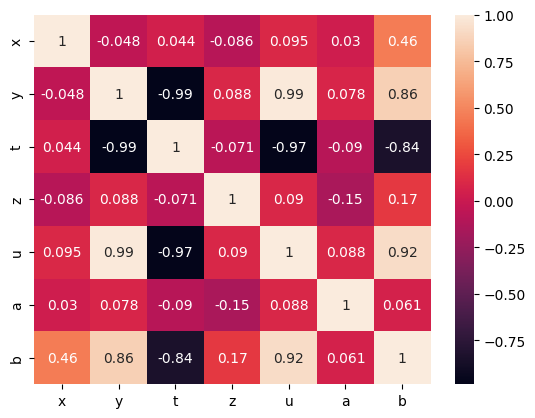

In [ ]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [ ]:
corr_matrix

,x,y,t,z,u,a
x,1.000000,-0.047693,0.044371,-0.086159,0.095358,0.030211
y,-0.047693,1.000000,-0.985824,0.088174,0.985568,0.077901
t,0.044371,-0.985824,1.000000,-0.070583,-0.971944,-0.090323
z,-0.086159,0.088174,-0.070583,1.000000,0.090361,-0.154472
u,0.095358,0.985568,-0.971944,0.090361,1.000000,0.088239
a,0.030211,0.077901,-0.090323,-0.154472,0.088239,1.000000


In [ ]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues

calculate_pvalues(df)

,x,y,t,z,u,a
x,0.0,0.5025,0.5327,0.2251,0.1792,0.6711
y,0.5025,0.0,0.0,0.2144,0.0,0.2729
t,0.5327,0.0,0.0,0.3206,0.0,0.2034
z,0.2251,0.2144,0.3206,0.0,0.2032,0.029
u,0.1792,0.0,0.0,0.2032,0.0,0.2141
a,0.6711,0.2729,0.2034,0.029,0.2141,0.0


**Осуждение со студентами.**
Какой вывод можно сделать по результатам корреляционного анализиа? Влияет ли $x$ на $u$? Надо ли включать $x$ в модель?

Визуализируем связь $x$ и $u$. Подтверждает ли график сделанные выводы?

То же вопрос про $t$ на $u$.

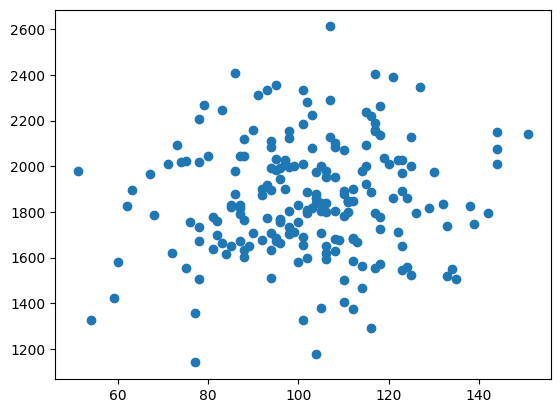

In [ ]:
plt.scatter(df['x'], df['u'])

Теперь узнаем, как данные были сгенерированы.

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(1)
sampleSize = 200

x = 20 * np.random.randn(sampleSize) + 100
y = 30 * np.random.randn(sampleSize) + 200
t = 300 - y + 5 * np.random.randn(sampleSize)
z = 5 * np.random.randn(sampleSize) + 20

u = 2 * x + 8 * y + z + 25 * np.random.randn(sampleSize) + 30

#df = pd.DataFrame(list(zip(x, y, t, z, u)), columns =['x', 'y', 't', 'z', 'u'])
#df = df.round(0)

Вид
$$u = 2 * x + 8 * y + z + \varepsilon,$$
где $\varepsilon$ --- нормальная случайная величина с мат. ожиданием = 30 и стандартным отклонением = 25,
ясно показывает, что связь $u$ с $x$ быть должна.

Почему же в корреляционном анализе эта связь получается статистически незначимая? Тот же попрос про $u$ и $z$.



In [ ]:
residuals = u - 8 * y
pearsonr(residuals, x)

PearsonRResult(statistic=0.8415383039329434, pvalue=7.455822694369336e-55)

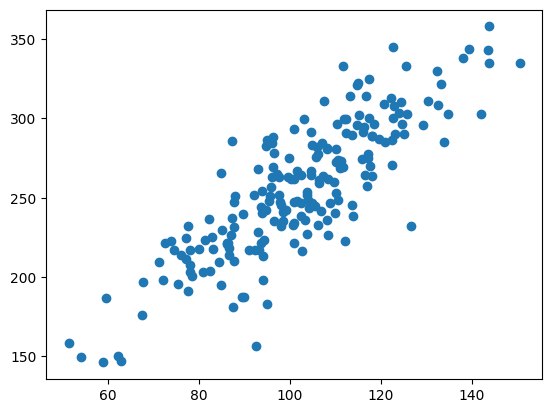

In [ ]:
plt.scatter(x, residuals)

Предиктор $x$ хорошо объясняет отстатки модели
$$u = Constanta + 8 * y.$$
Поэтому $x$ стоит включить в модель, сделав модель двухфакторной.

А предиктор $t$ что-то полезное внесет в модель $u = Constanta + 8* y$?

<Axes: xlabel='t', ylabel='u'>

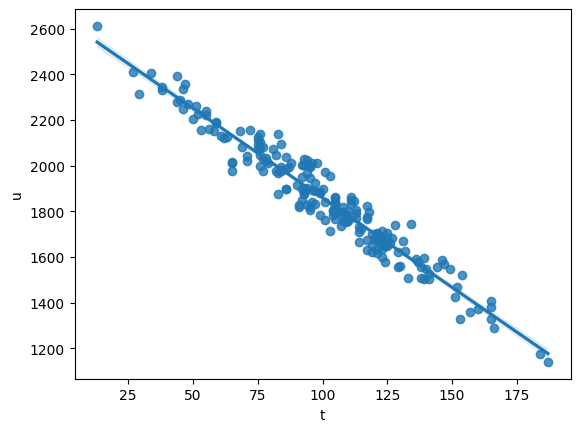

In [ ]:
sns.regplot(x="t", y="u", data=df)

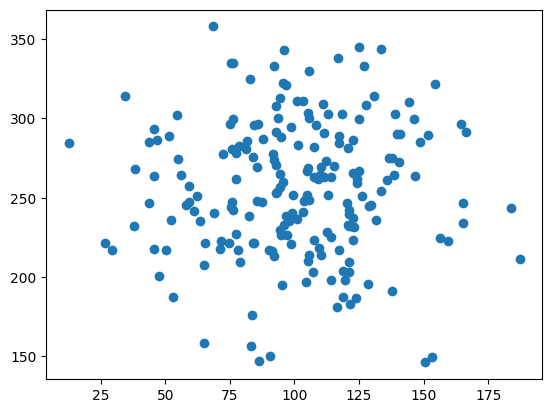

In [ ]:
plt.scatter(t, residuals)

Аналогично, по шагам включить в модель $x$ и $z.$

Можно ли было сразу понять, что $t$ не нужен в модели, зная о высокой корреляции $t$ и $y$?

Построим уравнение линейной регрессии, включив в модель все предикторы, в том числе заведомо ненужный "предиктор" $a$.

In [ ]:
#factors = df.iloc[:,[0:4,5]]
factors = df.iloc[:,[0, 1, 2, 3, 5]]
response = df.iloc[:,4]

model = LinearRegression()
model.fit(factors, response)

r_sq = model.score(factors, response)
print('Coefficient of determination', r_sq * 100, '%')
print('intercept_', model.intercept_)
print('Coefficient of determination', model.coef_)

Coefficient of determination 99.19765671736968 %
intercept_ 35.43867517021317
Coefficient of determination [ 1.98446323  7.97431144 -0.0336602   0.85076122  0.45696457]


Почему предиктор $t$, коотороый в корреляционном (однофакторном) анализе был значимым в модель включен с таким ничтожно малым (-0.0336602) коэффициентом? Даже при $a$ коэффициент больше.

А корректно ли сравнивать кэффициенты при $t$ и $a$ в уравнении регресии с тем, чтобы делать кикае-то выводы о силе влияния этих "предикторов" на $u$?

# Часть 2

Будем использовать методы из sklearn.feature_selection.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

**1 вариант** Univariate feature selection

class sklearn.feature_selection.SelectKBest(score_func=\<function f_classif\>, *, k=10)

В качестве первого аргумента нужно передавать функцию (score_funccallable, default=f_classif)

These objects take as input a scoring function that returns univariate scores and p-values (or only scores for SelectKBest and SelectPercentile):

* For regression: r_regression, f_regression, mutual_info_regression
* For classification: chi2, f_classif, mutual_info_classif

по умолчанию f_classif, которая подходит для задач классификации.

Мы решаем задачу регрессии, а потому будем использовать первый рекомендуемый r_regression.

In [ ]:
from sklearn.feature_selection import SelectKBest, r_regression

selector = SelectKBest(r_regression, k=2)

selector.fit(factors, response)

SelectKBest(k=2, score_func=<function r_regression at 0x7f5b17f93010>)

Метод SelectKBest(r_regression, k=2) выбрал два предиктора $x$ и $y$. Соответствует ли этот результат ранее полученным?

А если найти три лучших предиктора?

In [ ]:
print(selector.scores_)
print(selector.get_support())
print(selector.get_feature_names_out())

[ 0.09535849  0.98556829 -0.97194418  0.09036089  0.08823921]
[ True  True False False False]
['x' 'y']


Должны ли лучшие предикторы измениться, если предсказывать не $u$, а противоположный по знаку результат $-u$? Почему?

Проверим это.

In [ ]:
selector = SelectKBest(r_regression, k=2)

selector.fit(factors, -response)
print(selector.scores_)
print(selector.get_support())
print(selector.get_feature_names_out())

[-0.09535849 -0.98556829  0.97194418 -0.09036089 -0.08823921]
[False False  True False  True]
['t' 'a']


Выбраны заведомо худшие результаты. Почему так произошло?

Означаетли это, что метод SelectKBest не должен применяться в задачах поиска предикторов в множественной регрессии?

На странице sklearn.feature_selection.SelectKBest
внимательно читаем See also и находим список функций, которые могут быть использованы в качестве score_func. *Да, тут небольшое противоречие в документации, увы*.

f_regression
F-value between label/feature for regression tasks.

Объяснить, почему r_regression не подходит здесь для задач отбора признака. А где и для чего r_regression может быть использован?

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(f_regression, k=2)

selector.fit(factors, response)
#selector.fit(factors, -response)
print(selector.scores_)
print(selector.get_support())
print(selector.get_feature_names_out())

[1.81698404e+00 6.71175204e+03 3.38088336e+03 1.62999689e+00
 1.55375702e+00]
[False  True  True False False]
['y' 't']


Стал ли теперь результат инвариантен по отношению к знаку $u$? Можно ли теперь, когда используем правильную функцию для скоринга, применять метод SelectKBest для поиска предикторов, которые надо включить в модель множественной регрессии?

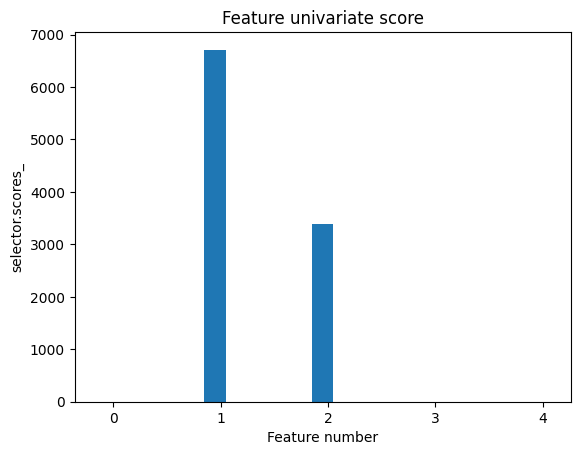

In [ ]:
import matplotlib.pyplot as plt


X_indices = np.arange(factors.shape[-1])
plt.figure(1)
plt.clf()
plt.bar(X_indices - 0.05, selector.scores_, width=0.2)
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel(r"selector.scores_")
plt.show()

**2 вариант**
Recursive feature elimination

Как работает sklearn.feature_selection.RFE?

Выбирает признак с наименьшим coef_ или feature_importances_ и удаляет его. Так повторяется, пока не останется заранее специфицированное число признаков.

Можно ли считать такой подход оправданным? Что такое стандартизация признаков? Как ее можно сделать и зачем?

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(factors, response)
selector.support_

array([ True,  True, False, False, False])

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression

selector = SelectFromModel(estimator=LinearRegression(), max_features = 2).fit(factors, response)

selector.get_support()

array([False,  True, False, False, False])

# Часть 3

Методы пошагового отбора типа Forward, Backward, Stepwise основаны на проверке статистических гипотез. При этом используется F-test.

https://online.stat.psu.edu/stat462/node/135/

In [ ]:
from sklearn.linear_model import LinearRegression
from scipy.stats import f
import math

sigLevel = 0.05

model = LinearRegression()
response  = df.iloc[:,-1]
sampleSize = len(response)
factorsNumber = len(df.columns) - 1
factorsToUse = [i for i in range(factorsNumber)]
[True] * factorsNumber
factorsInModel = []
factorsToTest = []

restrictedSSE = np.sum(np.square(response - response.mean()))

flag = True
while flag:
  fullSSE = [math.inf] * factorsNumber
  for i in factorsToUse:
    factorsToTest = factorsInModel[:]
    factorsToTest.append(i)
    model.fit(df.iloc[:, factorsToTest], response)
    pred = model.predict(df.iloc[:, factorsToTest])
    fullSSE[i] = np.sum(np.square(pred - response))

  factorCandidate = np.argmin(fullSSE)
  print('factorCandidate', factorCandidate)
  print('fullSSE', fullSSE)
  dfRmF = 1
  dfFull = sampleSize - len(factorsToTest) - 1
  F = ((restrictedSSE - fullSSE[factorCandidate]) / dfRmF) / (fullSSE[factorCandidate] / dfFull)
  print('F', F)
  pvalue = 1 - f.cdf(F, dfRmF, dfFull)

  if pvalue < sigLevel:
    restrictedSSE = fullSSE[factorCandidate]
    factorsInModel.append(factorCandidate)
    factorsToUse.remove(factorCandidate)
  else:
    flag = False

  print('pvalue', pvalue)
  print('factorsInModel', factorsInModel)
  print('\n----------------')

  if(len(factorsToTest) == 0):
    flag = False
    print('All are included')

factorCandidate 1
fullSSE [12512502.673527915, 361837.95500583027, 698600.735631178, 12524222.742020912, 12587664.708936056]
F 6711.752037952221
pvalue 1.1102230246251565e-16
factorsInModel [1]

----------------
factorCandidate 0
fullSSE [105334.29866455839, inf, 361783.9654883981, 361685.62102879316, 359596.3626518211]
F 479.7223785592327
pvalue 1.1102230246251565e-16
factorsInModel [1, 0]

----------------
factorCandidate 3
fullSSE [inf, inf, 105333.88131159669, 102391.99534022938, 104938.01133153944]
F 5.632192728076536
pvalue 0.018600669846179918
factorsInModel [1, 0, 3]

----------------
factorCandidate 4
fullSSE [inf, inf, 102370.5851511081, inf, 101966.40072597082]
F 0.8139048665986834
pvalue 0.36808128136317997
factorsInModel [1, 0, 3]

----------------


Здесь не разделяется обучающая и тестовая выборка.